In [2]:
import torch
import torchvision.transforms as TT
import matplotlib.pyplot as plt

In [3]:
import torchvision.transforms as TT

def cut_to_mnist(multi_img, merge_points):
    '''
        Cuts the input image (multi-digit) vertically by the merge_points and returns a list of images
        Input:
            multi_img: torch tensor to be cut into pieces
            merge_points: list of integers giving the horizontal-coordinate (in pixels) of the places to make the cut
        Output:
            A Python list of images.
    '''
    mnist_images = []
    top_vertical = 0
    top_horizontal = 0
    crop_height = 28
    crop_width = 0
    for mp in merge_points:
        mp = int(mp)
        crop_width = mp - top_horizontal
        cut_image =TT.functional.crop(multi_img, top=top_vertical, left=top_horizontal, height=crop_height, width=crop_width)
        top_horizontal = mp
        # fill or cut the image to 1 x 28 x 28 mnist shape:
        if(crop_width < 28):
            black_fill = torch.zeros([1,28,28 - cut_image.shape[2]])
            img = torch.cat([cut_image, black_fill], dim=2)
        elif(crop_width > 28):
            img = TT.functional.crop(cut_image, top=0, left=0, height=28, width=28)
        
        mnist_images.append(img)

    return mnist_images

In [4]:
# load example image:
import torchvision.transforms as TT
import matplotlib.pyplot as plt
from PIL import ImageDraw # used to draw lines on an image

mr = torch.load("test4/2312_21_45_67_93.pt")
print(mr)

t_img = mr["multi_img"]
print(f"mr[\"multi_img\"].shape : {t_img.shape}")

merge_points = mr["merge_points"]
print(f"merge_points: {merge_points}")

img = TT.ToPILImage()(mr["multi_img"])
plt.title(mr["multi_img_label"])
draw = ImageDraw.Draw(img)
for mp in merge_points:
    draw.line([(mp, 0), (mp, 28)], width=1, fill=128)
plt.imshow(img, cmap="gray")

FileNotFoundError: [Errno 2] No such file or directory: 'test4/2312_21_45_67_93.pt'

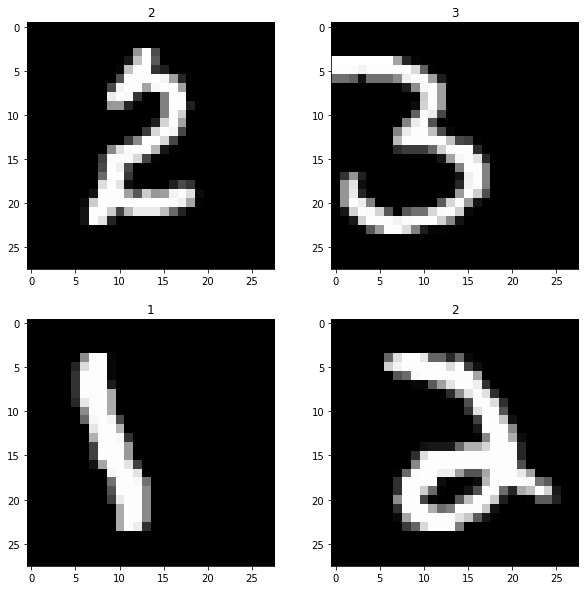

In [ ]:
# test cut_to_mnist() by displaying the single images:

import torchvision.transforms as TT
import matplotlib.pyplot as plt

torch_image_record = torch.load("test4/2312_21_45_67_93.pt")
torch_image = torch_image_record["multi_img"]
merge_points = torch_image_record["merge_points"]
multi_img_label = torch_image_record["multi_img_label"]

labels = [c for c in str(multi_img_label)]
torch_single_imgs = cut_to_mnist(torch_image, merge_points)

figure = plt.figure(figsize=(10,10))
rows, cols = 2,2
for i in range(1, cols * rows +1):
    img = torch_single_imgs[i-1]
    label = labels[i-1]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis="off"
    plt.imshow(img.squeeze(), cmap="gray")

In [ ]:
#from own module MultiDigitMnist_functions.py import SingleDigitMNISTNet
import torch
import MultiDigitMnist_functions as mdf
sys.path.append(".") # add current directory to module-search path - otherwize classes in modules are not found
from MultiDigitMnist_functions import SingleDigitMNISTNet
newmodel = SingleDigitMNISTNet()


In [ ]:
# save, load the mnist-classifier model via it's state-dict:

import os

MODE="load"
#MODE="save"

MODEL_PATH = os.path.join(os.getcwd(), "simplesaved_model_085val.pt")

if( MODE=="save"):
    torch.save(single_model.state_dict(), MODEL_PATH)

if ( MODE == "load"):
    #Load with this code:
    sys.path.append(".") # add current directory to module-search path - otherwise classes in modules are not found
    from MultiDigitMnist_functions import SingleDigitMNISTNet
    single_model = SingleDigitMNISTNet()
    single_model.load_state_dict(torch.load(MODEL_PATH))
    single_model.eval()

print(f"Finished {MODE}ing the model to {MODEL_PATH}.")

Finished loading the model to c:\Users\BoSc\Documents\9999_Public_Repository_Github\BSC Public Github\multi_digit_MNIST\simplesaved_model_085val.pt.


### Test the model on 4-digit numbers from the Mnist4_val directory: ###

In [ ]:
# test the model on 4-digit numbers from the Mnist4_val directory:
import random

val_dir = "Mnist4_val"
dir_path = os.path.join(os.getcwd(), val_dir)

# create a list of image names in the directory:
val_images_names = []
with os.scandir(dir_path) as dp:
    for record in dp:
        if record.name.endswith('pt'):
            val_images_names.append(record.name)

imaged_numbers=[]
recognized_numbers=[]

# extract the number on the image and the number recognized by the network:
for img_name in val_images_names:
    file_path = os.path.join(val_dir, img_name)
    torch_image_record = torch.load(file_path)
    torch_image = torch_image_record["multi_img"]
    merge_points = torch_image_record["merge_points"]
    multi_img_label = torch_image_record["multi_img_label"]
    snumber = "".join([str(c) for c in multi_img_label])
    imaged_numbers.append(snumber)

    torch_single_imgs = cut_to_mnist(torch_image, merge_points)
    preds = []
    for img in torch_single_imgs:
        pred = single_model(img.unsqueeze(dim=0))
        preds.append(torch.argmax(pred).item())

    recognized_numbers.append("".join([str(p) for p in preds]))

result = [ i==r for i,r in zip(imaged_numbers, recognized_numbers)]

print(f"There have been {sum(result)} correctly recognized 4-digit numbers.")
print(f"The accuracy is: acc={sum(result)/200 * 100:.1f}%")

# uncomment for some more information:
#print("image : recognition")
#for i, r in zip(imaged_numbers, recognized_numbers):
#    print(str(i) + " : " + str(r))

There have been 16 correctly recognized 4-digit numbers.
The accuracy is: acc=8.00%


### The overall performance of the 4-digit recognizer is quite low ###

With some easy probabilistic arguments this could have been foreseen (see next cell)


In [116]:
import math as m

# from the training of the single-mnist network we have:
one_digit_recog_probab=0.85


# probability of all 4 digits correctly recognized:
p_four_digit_recognized = one_digit_recog_probab**4
print(f"Probability of one correctly recognized 4-digit number: {p_four_digit_recognized:.2f}")

# probabilty for at least one 4-digit number out of 200 to be correctly recognized:
print(f"Probability of at least one correctly recognized 4-digit number out of 200: {1 - (1-p_four_digit_recognized)**200: .2f}")

print(f"Mean number of correctly recognized 4-digit numbers out of 200: {200 * p_four_digit_recognized:.2f}")

# necessary recog-probability of one digit for four digit correctly recognized with 0.95 probability: 0.95 = p**4 => p = exp(ln(0.95)/4)
print(f"Necessary single digit (Mnist) recognition probability for 95% propability to recognize a 4-digit number: {m.exp(m.log(0.95)/4):.4f} ")


Probability of one correctly recognized 4-digit number: 0.52
Probability of at least one correctly recognized 4-digit number out of 200:  1.00
Mean number of correctly recognized 4-digit numbers out of 200: 104.40
Necessary single digit (Mnist) recognition probability for 95% propability to recognize a 4-digit number: 0.9873 
